In [60]:
#libraries
library(pracma)
library(ggplot2)
library(maps) 
library(patchwork)

In [5]:
rm(list = ls())

setwd("/home/yow004/Projects/NonergodicSD")

#user functions
source('R_lib/regression/inla/regression_inla_model1_unbounded_hyp.R')


#regression name
reg_name  <- 'SD_regression_ds1_inla'

#input file
flatfile_fname <- 'data/compile_all.csv'

#output directory
dir_out <- 'data/SD_trugman_ds1_inla/'

#INLA regression parameters
runinla_flag <- TRUE # TRUE or FALSE
res_name     <- 'tot_trugman'
#res_name <- 'tot'
#mesh coarseness
# #fine
# mesh_edge_max     <- 5
# mesh_inner_offset <- 15
# mesh_outer_offset <- 15
# #medium
# mesh_edge_max     <- 15
# mesh_inner_offset <- 15
# mesh_outer_offset <- 50
#coarse
mesh_edge_max     <- 40
mesh_inner_offset <- 40
mesh_outer_offset <- 45

#approximation options
# if flag_gp_approx=TRUE uses int.strategy="eb" and strategy="gaussian"
# int.strategy="eb" corresponds to one integration point, and 
# strategy="gaussian" approximates posteriors as gaussian distributions
flag_gp_approx <- TRUE # TRUE or FALSE

#number of threads
# reduce number of threads if running out of memmory, if not specified
# number of CPU threads is used
n_threads <- 4

In [6]:
df_flatfile <- read.csv(flatfile_fname)
df_flatfile[,'tot_trugman']<-df_flatfile[,'PGA']-df_flatfile[,'pPGA']


In [7]:

colnames(df_flatfile)[which(names(df_flatfile) == "eqlat")] <- "eqLat"
colnames(df_flatfile)[which(names(df_flatfile) == "eqlon")] <- "eqLon"
colnames(df_flatfile)[which(names(df_flatfile) == "stalat")] <- "staLat"
colnames(df_flatfile)[which(names(df_flatfile) == "stalon")] <- "staLon"


In [8]:
  # Preprocess Input Data
  # ---------------------------
  n_data <- nrow(df_flatfile)
  #earthquake data
  data_eq_all <- df_flatfile[,c('eqid','mag','eqX', 'eqY')]
  out_unq  <- UniqueIdxInv(df_flatfile[,'eqid'])
  eq_idx   <- out_unq$idx
  eq_inv   <- out_unq$inv
  data_eq  <- data_eq_all[eq_idx,]
  X_eq     <- data_eq[,c(3,4)] #earthquake coordinates
  X_eq_all <- data_eq_all[,c(3,4)]
  #create earthquake ids for all records (1 to n_eq)
  eq_id <- eq_inv
  n_eq  <- nrow(data_eq)
  
  #station data
  data_sta_all <- df_flatfile[,c('ssn','Vs30','staX','staY')]
  out_unq   <- UniqueIdxInv(df_flatfile[,'ssn'])
  sta_idx   <- out_unq$idx
  sta_inv   <- out_unq$inv
  data_sta  <- data_sta_all[sta_idx,]
  X_sta     <- data_sta[,c(3,4)] #station coordinates
  X_sta_all <- data_sta_all[,c(3,4)]
  #create station indices for all records (1 to n_sta)
  sta_id <- sta_inv
  n_sta  <- nrow(data_sta)
  
  #ground-motion observations  
  y_data <- df_flatfile[,res_name]
  
  #UTM zone
  utm_zone <- unique(df_flatfile$UTMzone)
  utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))

In [9]:
df_flatfile[,'rsn'] <- 1:n_data

In [10]:
# Run INLA, fit model 
  # ---------------------------
  #fixed effects 
  #---   ---   ---   ---   ---   ---
  #prior on the fixed effects
  prior_fixed <- list(mean.intercept = 0, prec.intercept = 5,
                      mean = (list(intcp=0.0, default=0)),
                      prec = (list(intcp=5.0, default=0.01)))
  
  #covariates
  df_inla_covar <- data.frame(intcp = 1, eq = eq_id, sta = sta_id)
  
  #spatial model
  #---   ---   ---   ---   ---   ---
  #input arguments
  edge_max     <- mesh_edge_max
  inner_offset <- mesh_inner_offset
  outer_offset <- mesh_outer_offset

In [11]:
#domain mesh
mesh <- inla.mesh.2d(loc=rbind(as.matrix(X_eq),as.matrix(X_sta)) ,
                    max.edge = c(1,5)*edge_max,
                    cutoff = 3, offset = c(inner_offset, outer_offset))

as(<dgCMatrix>, "dgTMatrix") is deprecated since Matrix 1.5-0; do as(., "TsparseMatrix") instead



Warning message:
“Removed 65 row(s) containing missing values (geom_path).”


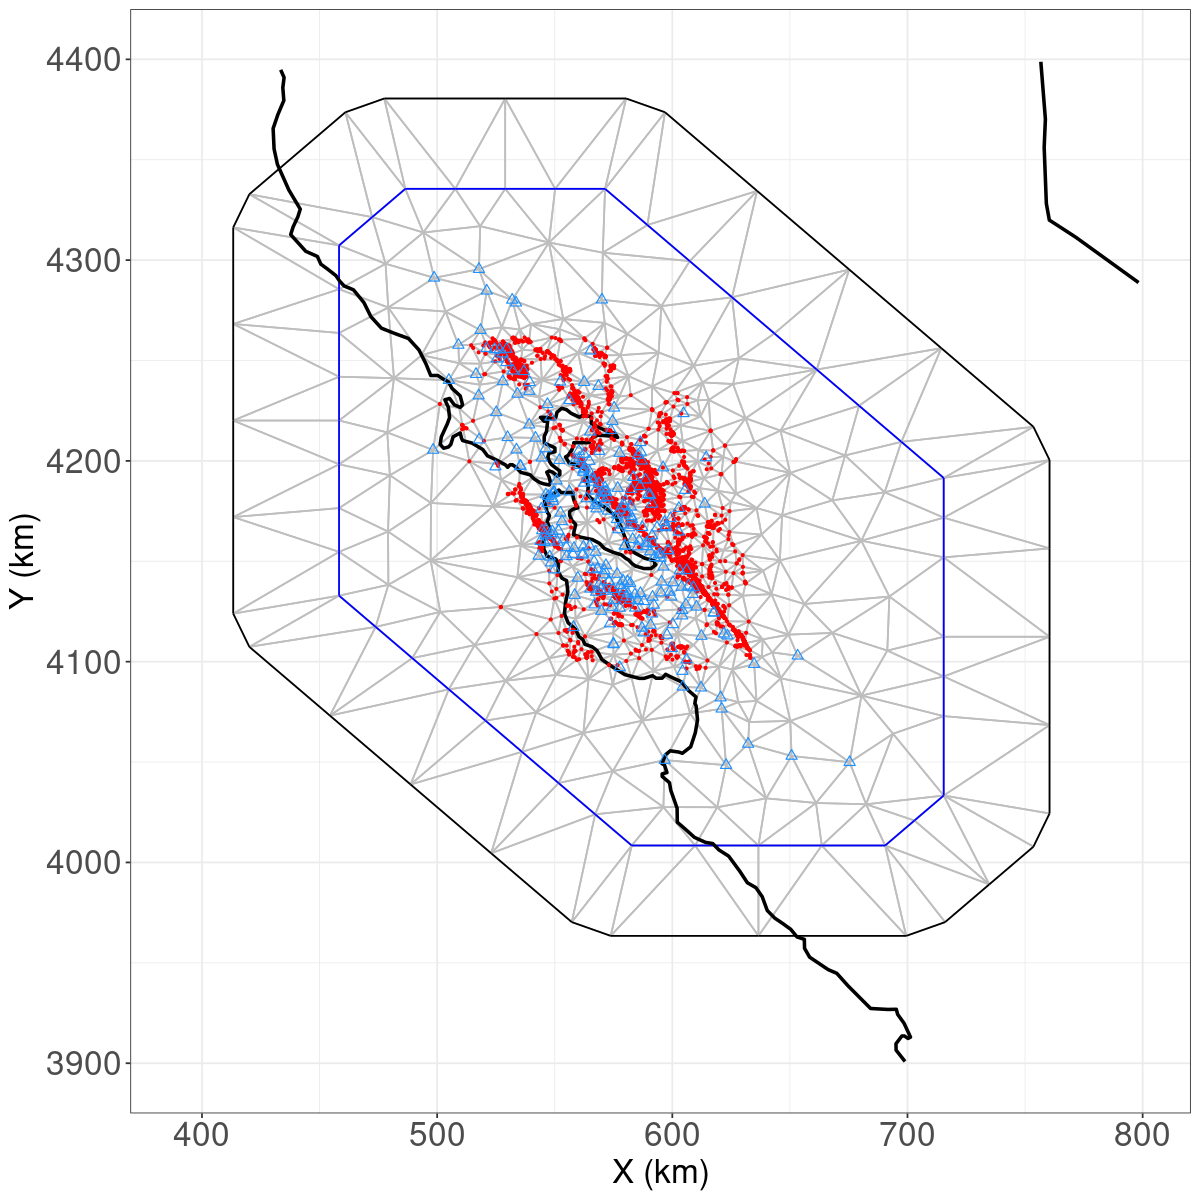

In [12]:
options(repr.plot.width=10, repr.plot.height=10)
# Plotting
# ---------------------------    
#plotting info
set1   <- RColorBrewer::brewer.pal(7, "Set1") #color map
#California
map_ca <- subset( map_data("state"), region %in% c("california"))
map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000
#Nevada
map_nv <- subset( map_data("state"), region %in% c("nevada"))
map_nv_utm <- LongLatToUTM(lat=map_nv$lat, lon=map_nv$long, utm_no)
map_nv[,c('X','Y')] <- map_nv_utm[,c('X','Y')]/1000


  #Earthquake - Station Mesh
  pl_mesh  <- ggplot() + theme_bw() + gg(mesh) +
              geom_path(data=map_ca, aes(x=X,y=Y), color='black',size=1) +
              geom_point(data=X_eq, aes(x=eqX,y=eqY),size=0.5,color='red') +
              geom_point(data=X_sta, aes(x=staX,y=staY),size=2,shape=2,color='dodgerblue') +
              scale_size_manual(values=c(2.0,0.5), labels = c('Earthquakes','Stations'), name=element_blank()) + 
              scale_color_manual(values=c(set1[1],set1[2]), labels = c('Earthquakes','Stations'), name=element_blank()) + 
              labs(x="X (km)", y="Y (km)") +
              xlim(390,800) + ylim(3900,4400) +
              theme(plot.title=element_text(size=20), axis.title=element_text(size=20), 
                    axis.text.y=element_text(size=20), axis.text.x=element_text(size=20),
                    legend.key.size = unit(1, 'cm'), legend.text=element_text(size=20), 
                    legend.position = c(0.20, 0.10))
print(pl_mesh)


In [13]:
alpha = 2
out_dir <- dir_out
out_fname <- reg_name
#prior distributions
  #site independent term
  prior_omega_1bs <- list(prec = list(prior = "loggamma", param = c(0.9, 0.007)))
  #spde earthquake prior
  spde_eq <- inla.spde2.pcmatern(mesh = mesh, alpha = alpha, # Mesh and smoothness parameter
                                 prior.range = c(100, 0.95), # P(range < 100) = 0.95
                                 prior.sigma = c(.30, 0.1))  # P(sigma > 0.30) = 0.10
  #spde station prior
  spde_sta <- inla.spde2.pcmatern(mesh = mesh, alpha = alpha, # Mesh and smoothness parameter
                                  prior.range = c(100, 0.95), # P(range < 100) = 0.95
                                  prior.sigma = c(.40, 0.1))  # P(sigma > 0.40) = 0.10
  
  A_eq    <- inla.spde.make.A(mesh, loc = as.matrix(X_eq_all))
  idx.eq  <- inla.spde.make.index("idx.eq",spde_eq$n.spde)
  A_sta   <- inla.spde.make.A(mesh, loc = as.matrix(X_sta_all))
  idx.sta <- inla.spde.make.index("idx.sta",spde_sta$n.spde)

In [14]:
#aleatory terms
  #---   ---   ---   ---   ---   ---
  #prior distributions
  prior_phi_0 <- list(prec = list(prior = "loggamma", param = c(5.0, 0.5)))
  prior_tau_0 <- list(prec = list(prior = "loggamma", param = c(4.0, 0.5)))

In [15]:
#inla model
  #---   ---   ---   ---   ---   ---
  #functional form (with spatial var)
  form_inla_spatial <- y ~ 0 + intcp + 
                           f(eq, model="iid", hyper=prior_tau_0) + f(sta, model="iid", hyper=prior_omega_1bs) +
                           f(idx.eq, model = spde_eq) + f(idx.sta, model = spde_sta) 
  
  #build stack
  stk_inla_spatial <- inla.stack(data = list(y = y_data),
                                 A = list(A_eq, A_sta, 1),
                                 effects = list(idx.eq = idx.eq,
                                                idx.sta = idx.sta,
                                                df_inla_covar),
                                 tag = 'model_inla_spatial')
  

In [16]:
  #fit inla model
  #---   ---   ---   ---   ---   ---
  if(runinla_flag){
    #run model (spatial)
    if(flag_gp_approx == TRUE){
      fit_inla_spatial <- inla(form_inla_spatial, 
                               data = inla.stack.data(stk_inla_spatial),
                               family="gaussian",
                               control.family = list(hyper = list(prec = prior_phi_0)),
                               control.fixed = prior_fixed,
                               control.predictor = list(A = inla.stack.A(stk_inla_spatial)),
                               control.compute = list(dic = TRUE, cpo = TRUE, waic = TRUE),
                               control.inla = list(int.strategy='eb', strategy="gaussian"),
                               verbose=TRUE,  num.threads=n_threads)
    }else{
      fit_inla_spatial <- inla(form_inla_spatial, 
                               data = inla.stack.data(stk_inla_spatial),
                               family="gaussian",
                               control.family = list(hyper = list(prec = prior_phi_0)),
                               control.fixed = prior_fixed,
                               control.predictor = list(A = inla.stack.A(stk_inla_spatial)),
                               control.compute = list(dic = TRUE, cpo = TRUE, waic = TRUE),
                               verbose=TRUE,  num.threads=n_threads)
    }
    #save results
    dir.create(out_dir, showWarnings=FALSE, recursive=TRUE)
    save(fit_inla_spatial, file=file.path(out_dir,paste0(out_fname,'_inla_fit','.Rdata')) )
  }else{
    #load results
    load(file.path(out_dir,paste0(out_fname,'_inla_fit','.Rdata')) )
  }

In [17]:
## Post-processing Results
  # ---------------------------
  #hyper-parameters
  hyp_param <- data.frame(matrix(ncol = 6, nrow = 0))
  colnames(hyp_param) <- colnames(fit_inla_spatial$summary.hyperpar)

  hyp_param['dc_0',]    <- fit_inla_spatial$summary.fixed['intcp',]
  #correlation lengths of spatial terms
  hyp_param['ell_1e',]  <- fit_inla_spatial$summary.hyperpar['Range for idx.eq',]
  hyp_param['ell_1as',] <- fit_inla_spatial$summary.hyperpar['Range for idx.sta',]
  #standard deviations of spatial terms
  hyp_param['omega_1e',]  <- fit_inla_spatial$summary.hyperpar['Stdev for idx.eq',]
  hyp_param['omega_1as',] <- fit_inla_spatial$summary.hyperpar['Stdev for idx.sta',]  
  hyp_param['omega_1bs',] <- 1/sqrt(fit_inla_spatial$summary.hyperpar['Precision for sta',] ) 
  #aleatory terms
  hyp_param['phi_0',] <- 1/sqrt( fit_inla_spatial$summary.hyperpar['Precision for the Gaussian observations',] )
  hyp_param['tau_0',] <- 1/sqrt( fit_inla_spatial$summary.hyperpar['Precision for eq',] )
  #unavailable sd for transformed variables
  hyp_param[c('omega_1bs','phi_0','tau_0'),'sd'] <- NA

Warning message in `[<-.data.frame`(`*tmp*`, "dc_0", , value = structure(list(mean = 0.00844056234178193, :
“provided 7 variables to replace 6 variables”


In [18]:
#projections
  prjct_grid_eq  <- inla.mesh.projector(mesh, loc = as.matrix(X_eq))
  prjct_grid_sta <- inla.mesh.projector(mesh, loc = as.matrix(X_sta))
  
  #coefficients    
  coeff_1e  <- fit_inla_spatial$summary.random$idx.eq
  coeff_1as <- fit_inla_spatial$summary.random$idx.sta
  coeff_1bs <- fit_inla_spatial$summary.random$sta
  #coeff mean and std
  coeff_1e_mu   <- inla.mesh.project(prjct_grid_eq,  coeff_1e$mean)
  coeff_1e_sig  <- inla.mesh.project(prjct_grid_eq,  coeff_1e$sd)
  coeff_1as_mu  <- inla.mesh.project(prjct_grid_sta, coeff_1as$mean)
  coeff_1as_sig <- inla.mesh.project(prjct_grid_sta, coeff_1as$sd)
  coeff_1bs_mu  <- coeff_1bs$mean
  coeff_1bs_sig <- coeff_1bs$sd

In [19]:
#mean prediction
  y_new_mu <- hyp_param['dc_0','mean'] + coeff_1e_mu[eq_inv] + coeff_1as_mu[sta_inv] + coeff_1bs_mu[sta_inv] 
  
  #residuals
  res_tot_mu <- y_data - y_new_mu
  res_dB_mu  <- fit_inla_spatial$summary.random$eq$mean[eq_inv]
  res_dWS_mu <- res_tot_mu - res_dB_mu
  
  ## Summarize coefficients and residuals
  # ---------------------------
  df_flatinfo  <- df_flatfile[,c('rsn','eqid','ssn','eqLat','eqLon','staLat','staLon','eqX','eqY','staX','staY')]
  
  #summary coefficients
  df_coeff <- data.frame(rsn=df_flatinfo$rsn,
                         dc_0_mean=hyp_param['dc_0','mean'],
                         dc_1e_mean=coeff_1e_mu[eq_inv],  
                         dc_1as_mean=coeff_1as_mu[sta_inv],
                         dc_1bs_mean=coeff_1bs_mu[sta_inv], 
                         dc_0_sig=hyp_param['dc_0','sd'], 
                         dc_1e_sig=coeff_1e_sig[eq_inv], 
                         dc_1as_sig=coeff_1as_sig[sta_inv], 
                         dc_1bs_sig=coeff_1bs_sig[sta_inv])
  df_coeff <- merge(df_flatinfo, df_coeff, by=c('rsn'))
  
  #summary predictions and residuals
  df_predict_summary <- data.frame(rsn=df_flatinfo$rsn, nerg_mu=y_new_mu, 
                                   res_tot=res_tot_mu, res_between=res_dB_mu, res_within=res_dWS_mu)
  df_predict_summary <- merge(df_flatinfo, df_predict_summary, by=c('rsn'))


In [20]:
  ## Posterior distributions
  # ---------------------------
  #intercept
  post_dc_0 <- as.data.frame(fit_inla_spatial$marginals.fixed$intcp)
  #aleatory parameters
  post_phi_0 <- as.data.frame(inla.tmarginal(function(x) exp(-x/2), fit_inla_spatial$internal.marginals.hyperpar[['Log precision for the Gaussian observations']]))
  post_tau_0 <- as.data.frame(inla.tmarginal(function(x) exp(-x/2), fit_inla_spatial$internal.marginals.hyperpar[['Log precision for eq']]))
  #non-ergodic scales
  post_omega_1e  <- as.data.frame(inla.tmarginal(function(x) exp( x),   fit_inla_spatial$internal.marginals.hyperpar[['log(Stdev) for idx.eq']]))
  post_omega_1as <- as.data.frame(inla.tmarginal(function(x) exp( x),   fit_inla_spatial$internal.marginals.hyperpar[['log(Stdev) for idx.sta']]))
  post_omega_1bs <- as.data.frame(inla.tmarginal(function(x) exp(-x/2), fit_inla_spatial$internal.marginals.hyperpar[['Log precision for sta']]))
  #correlation length
  post_ell_1e   <- as.data.frame(inla.tmarginal(function(x) exp( x), fit_inla_spatial$internal.marginals.hyperpar[['log(Range) for idx.eq']]))
  post_ell_1as  <- as.data.frame(inla.tmarginal(function(x) exp( x), fit_inla_spatial$internal.marginals.hyperpar[['log(Range) for idx.sta']]))
  
  #compute posterior cdfs
  post_dc_0$y_int      <- cumtrapz(post_dc_0$x, post_dc_0$y)   / trapz(post_dc_0$x, post_dc_0$y)
  post_phi_0$y_int     <- cumtrapz(post_phi_0$x, post_phi_0$y) / trapz(post_phi_0$x, post_phi_0$y)
  post_tau_0$y_int     <- cumtrapz(post_tau_0$x, post_tau_0$y) / trapz(post_tau_0$x, post_tau_0$y)
  post_omega_1e$y_int  <- cumtrapz(post_omega_1e$x, post_omega_1e$y)   / trapz(post_omega_1e$x, post_omega_1e$y)
  post_omega_1as$y_int <- cumtrapz(post_omega_1as$x, post_omega_1as$y) / trapz(post_omega_1as$x, post_omega_1as$y)
  post_omega_1bs$y_int <- cumtrapz(post_omega_1bs$x, post_omega_1bs$y) / trapz(post_omega_1bs$x, post_omega_1bs$y)
  post_ell_1e$y_int    <- cumtrapz(post_ell_1e$x, post_ell_1e$y)       / trapz(post_ell_1e$x, post_ell_1e$y)
  post_ell_1as$y_int   <- cumtrapz(post_ell_1as$x, post_ell_1as$y)     / trapz(post_ell_1as$x, post_ell_1as$y)
  
  #posterior distributions
  #define quantiles
  hyp_posterior <- data.frame(quant=seq(0.0,1.0,0.01))
  #compute pdf and cdf
  if (! all(is.na(post_dc_0$y_int))){
    hyp_posterior$dc_0          <- approx(post_dc_0$y_int,      post_dc_0$x,      hyp_posterior$quant)$y
    hyp_posterior$dc_0_pdf      <- approx(post_dc_0$y_int,      post_dc_0$y,      hyp_posterior$quant)$y
  } else {
    hyp_posterior$dc_0          <- NaN
    hyp_posterior$dc_0_pdf      <- NaN
  }
  if (! all(is.na(post_ell_1e$y_int))){
    hyp_posterior$ell_1e        <- approx(post_ell_1e$y_int,    post_ell_1e$x,    hyp_posterior$quant)$y
    hyp_posterior$ell_1e_pdf    <- approx(post_ell_1e$y_int,    post_ell_1e$y,    hyp_posterior$quant)$y
  } else {
    hyp_posterior$ell_1e        <- NaN
    hyp_posterior$ell_1e_pdf    <- NaN
  }
  if (! all(is.na(post_ell_1as$y_int))){  
    hyp_posterior$ell_1as       <- approx(post_ell_1as$y_int,   post_ell_1as$x,   hyp_posterior$quant)$y
    hyp_posterior$ell_1as_pdf   <- approx(post_ell_1as$y_int,   post_ell_1as$y,   hyp_posterior$quant)$y
  } else {
    hyp_posterior$ell_1as       <- NaN
    hyp_posterior$ell_1as_pdf   <- NaN
  }
  if (! all(is.na(post_omega_1e$y_int))){  
    hyp_posterior$omega_1e      <- approx(post_omega_1e$y_int,  post_omega_1e$x,  hyp_posterior$quant)$y
    hyp_posterior$omega_1e_pdf  <- approx(post_omega_1e$y_int,  post_omega_1e$y,  hyp_posterior$quant)$y
  } else {
    hyp_posterior$omega_1e      <- NaN
    hyp_posterior$omega_1e_pdf  <- NaN
  }
  if (! all(is.na(post_omega_1as$y_int))){  
    hyp_posterior$omega_1as     <- approx(post_omega_1as$y_int, post_omega_1as$x, hyp_posterior$quant)$y
    hyp_posterior$omega_1as_pdf <- approx(post_omega_1as$y_int, post_omega_1as$y, hyp_posterior$quant)$y
  } else {
    hyp_posterior$omega_1as     <- NaN
    hyp_posterior$omega_1as_pdf <- NaN
  }
  if (! all(is.na(post_omega_1bs$y_int))){  
    hyp_posterior$omega_1bs     <- approx(post_omega_1bs$y_int, post_omega_1bs$x, hyp_posterior$quant)$y
    hyp_posterior$omega_1bs_pdf <- approx(post_omega_1bs$y_int, post_omega_1bs$y, hyp_posterior$quant)$y
  } else {
    hyp_posterior$omega_1bs     <- NaN
    hyp_posterior$omega_1bs_pdf <- NaN
  }
  if  (! all(is.na(post_phi_0$y_int))){  
    hyp_posterior$phi_0         <- approx(post_phi_0$y_int,     post_phi_0$x,     hyp_posterior$quant)$y
    hyp_posterior$phi_0_pdf     <- approx(post_phi_0$y_int,     post_phi_0$y,     hyp_posterior$quant)$y
  } else {
    hyp_posterior$phi_0         <- NaN
    hyp_posterior$phi_0_pdf     <- NaN
  }
  if  (! all(is.na(post_tau_0$y_int))){  
    hyp_posterior$tau_0         <- approx(post_tau_0$y_int,     post_tau_0$x,     hyp_posterior$quant)$y
    hyp_posterior$tau_0_pdf     <- approx(post_tau_0$y_int,     post_tau_0$y,     hyp_posterior$quant)$y
  } else {
    hyp_posterior$tau_0         <- NaN
    hyp_posterior$tau_0_pdf     <- NaN
  }
  

In [34]:
# Plotting
  # ---------------------------    
  #plotting info
  set1   <- RColorBrewer::brewer.pal(7, "Set1") #color map
  #California
  map_ca <- subset( map_data("state"), region %in% c("california"))
  map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
  map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000
  #Nevada
  map_nv <- subset( map_data("state"), region %in% c("nevada"))
  map_nv_utm <- LongLatToUTM(lat=map_nv$lat, lon=map_nv$long, utm_no)
  map_nv[,c('X','Y')] <- map_nv_utm[,c('X','Y')]/1000
  
  #Earthquake - Station Mesh
  pl_mesh  <- ggplot() + theme_bw() + gg(mesh) +
              geom_path(data=map_ca, aes(x=X,y=Y), color='black') + geom_path(data=map_nv, aes(x=X,y=Y), color='black')+
              geom_point(data=X_eq, aes(x=eqX,y=eqY, size=as.factor('EQ'), color=as.factor('EQ'))) +
              geom_point(data=X_sta, aes(x=staX,y=staY, size=as.factor('STA'), color=as.factor('STA'))) +
              scale_size_manual(values=c(2.0,0.5), labels = c('Earthquakes','Stations'), name=element_blank()) + 
              scale_color_manual(values=c(set1[1],set1[2]), labels = c('Earthquakes','Stations'), name=element_blank()) + 
              labs(x="X (km)", y="Y (km)") +
              xlim(390,800) + ylim(3900,4400) +
              theme(plot.title=element_text(size=20), axis.title=element_text(size=20), 
                    axis.text.y=element_text(size=20), axis.text.x=element_text(size=20),
                    legend.key.size = unit(1, 'cm'), legend.text=element_text(size=20), 
                    legend.position = c(0.20, 0.10))

  # plot of non-ergodic terms mean and sd of spatially varying event terms
  #dc_1e map mean
  pl_dc_1e_mu_map <- ggplot() + theme_bw() + xlim(390,800) + ylim(3900,4400)
  pl_dc_1e_mu_map <- plot_field(coeff_1e$mean, mesh, xrange=c(-200,800), yrange=c(3400,4750), pl=pl_dc_1e_mu_map) + scico::scale_fill_scico(palette = "vik")
  pl_dc_1e_mu_map <- pl_dc_1e_mu_map + geom_path(data=map_ca, aes(x=X,y=Y), color='black') + geom_path(data=map_nv, aes(x=X,y=Y), color='black') +
                     geom_point(data=X_eq, aes(x=eqX,y=eqY), color=I("black"), size=0.4) +
                     labs(x="X (km)", y="Y (km)") + theme(axis.title = element_text(size=20), axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))
  #dc_1e map sigma
  pl_dc_1e_sd_map <- ggplot() + theme_bw()+ xlim(390,800) + ylim(3900,4400)
  pl_dc_1e_sd_map <- plot_field(coeff_1e$sd, mesh, xrange=c(-200,800), yrange=c(3400,4750), pl=pl_dc_1e_sd_map)
  pl_dc_1e_sd_map <- pl_dc_1e_sd_map + geom_path(data=map_ca, aes(x=X,y=Y), color='black') + geom_path(data=map_nv, aes(x=X,y=Y), color='black') +
                     geom_point(data=X_eq, aes(x=eqX,y=eqY), color=I("black"), size=0.4) +
                     labs(x="X (km)", y="Y (km)") + theme(axis.title = element_text(size=20), axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))
  #dc_1as map mean
  pl_dc_1as_mu_map <- ggplot() + theme_bw()+ xlim(390,800) + ylim(3900,4400)
  pl_dc_1as_mu_map <- plot_field(coeff_1as$mean, mesh, xrange=c(-200,800), yrange=c(3400,4750), pl=pl_dc_1as_mu_map) + scico::scale_fill_scico(palette = "vik")
  pl_dc_1as_mu_map <- pl_dc_1as_mu_map + geom_path(data=map_ca, aes(x=X,y=Y), color='black') + geom_path(data=map_nv, aes(x=X,y=Y), color='black') +
                      geom_point(data=X_sta, aes(x=staX,y=staY), color=I("black"), size=0.2) +
                      labs(x="X (km)", y="Y (km)") + theme(axis.title = element_text(size=20), axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))
  #dc_1as map sigma
  pl_dc_1as_sd_map <- ggplot() + theme_bw()+ xlim(390,800) + ylim(3900,4400)
  pl_dc_1as_sd_map <- plot_field(coeff_1as$sd, mesh, xrange=c(-200,800), yrange=c(3400,4750), pl=pl_dc_1as_sd_map)
  pl_dc_1as_sd_map <- pl_dc_1as_sd_map + geom_path(data=map_ca, aes(x=X,y=Y), color='black') + geom_path(data=map_nv, aes(x=X,y=Y), color='black') +
                      geom_point(data=X_sta, aes(x=staX,y=staY), color=I("black"), size=0.2) +
                      labs(x="X (km)", y="Y (km)") + theme(axis.title = element_text(size=20), axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))
  
  #posterior distributions
  #dc_0
  pl_dc_0_post <- ggplot(post_dc_0, aes(x,y)) + theme_bw() + geom_line() + 
                  geom_vline(xintercept = hyp_param['dc_0','mean'], colour = "red") +
                  labs(x = 'dc_0', y = 'posterior', title='Posterior dc_0') + 
                  theme(plot.title=element_text(size=20), axis.title=element_text(size=20), axis.text.y=element_text(size=20), axis.text.x=element_text(size=20))
  #omega_1e
  pl_omega_1e_post <- ggplot(post_omega_1e, aes(x,y)) + theme_bw() + geom_line() + 
                      geom_vline(xintercept = hyp_param['omega_1e','mean'], colour = "red") +
                      labs(x = 'omega_1e', y = 'posterior', title='Posterior omega_1e') + 
                      theme(plot.title=element_text(size=20), axis.title=element_text(size=20), axis.text.y=element_text(size=20), axis.text.x=element_text(size=20))
  #omega_1as
  pl_omega_1as_post <- ggplot(post_omega_1as, aes(x,y)) + theme_bw() + geom_line() + 
                       geom_vline(xintercept = hyp_param['omega_1as','mean'], colour = "red") +
                       labs(x = 'omega_1as', y = 'posterior', title='Posterior omega_1as') + 
                       theme(plot.title=element_text(size=20), axis.title=element_text(size=20), axis.text.y=element_text(size=20), axis.text.x=element_text(size=20))
  #omega_1bs
  pl_omega_1bs_post <- ggplot(post_omega_1bs, aes(x,y)) + theme_bw() + geom_line() + 
                       geom_vline(xintercept = hyp_param['omega_1bs','mean'], colour = "red") +
                       labs(x = 'omega_1bs', y = 'posterior', title='Posterior omega_1bs') + 
                       theme(plot.title=element_text(size=20), axis.title=element_text(size=20), axis.text.y=element_text(size=20), axis.text.x=element_text(size=20))
  #ell_1e
  pl_ell_1e_post <- ggplot(post_ell_1e, aes(x,y)) + theme_bw() + geom_line() + 
                    geom_vline(xintercept = hyp_param['ell_1e','mean'], colour = "red") +
                    labs(x = 'ell_1e', y = 'posterior', title='Posterior ell_1e') + 
                    theme(plot.title=element_text(size=20), axis.title=element_text(size=20), axis.text.y=element_text(size=20), axis.text.x=element_text(size=20))
  #ell_1as
  pl_ell_1as_post <- ggplot(post_ell_1as, aes(x,y)) + theme_bw() + geom_line() + 
                     geom_vline(xintercept = hyp_param['ell_1as','mean'], colour = "red") +
                     labs(x = 'ell_1as', y = 'posterior', title='Posterior ell_1as') + 
                     theme(plot.title=element_text(size=20), axis.title=element_text(size=20), axis.text.y=element_text(size=20), axis.text.x=element_text(size=20))

Warning message:
“Removed 65 row(s) containing missing values (geom_path).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”
Warning message:
“Removed 65 row(s) containing missing values (geom_path).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”
Warning message:
“Removed 65 row(s) containing missing values (geom_path).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”


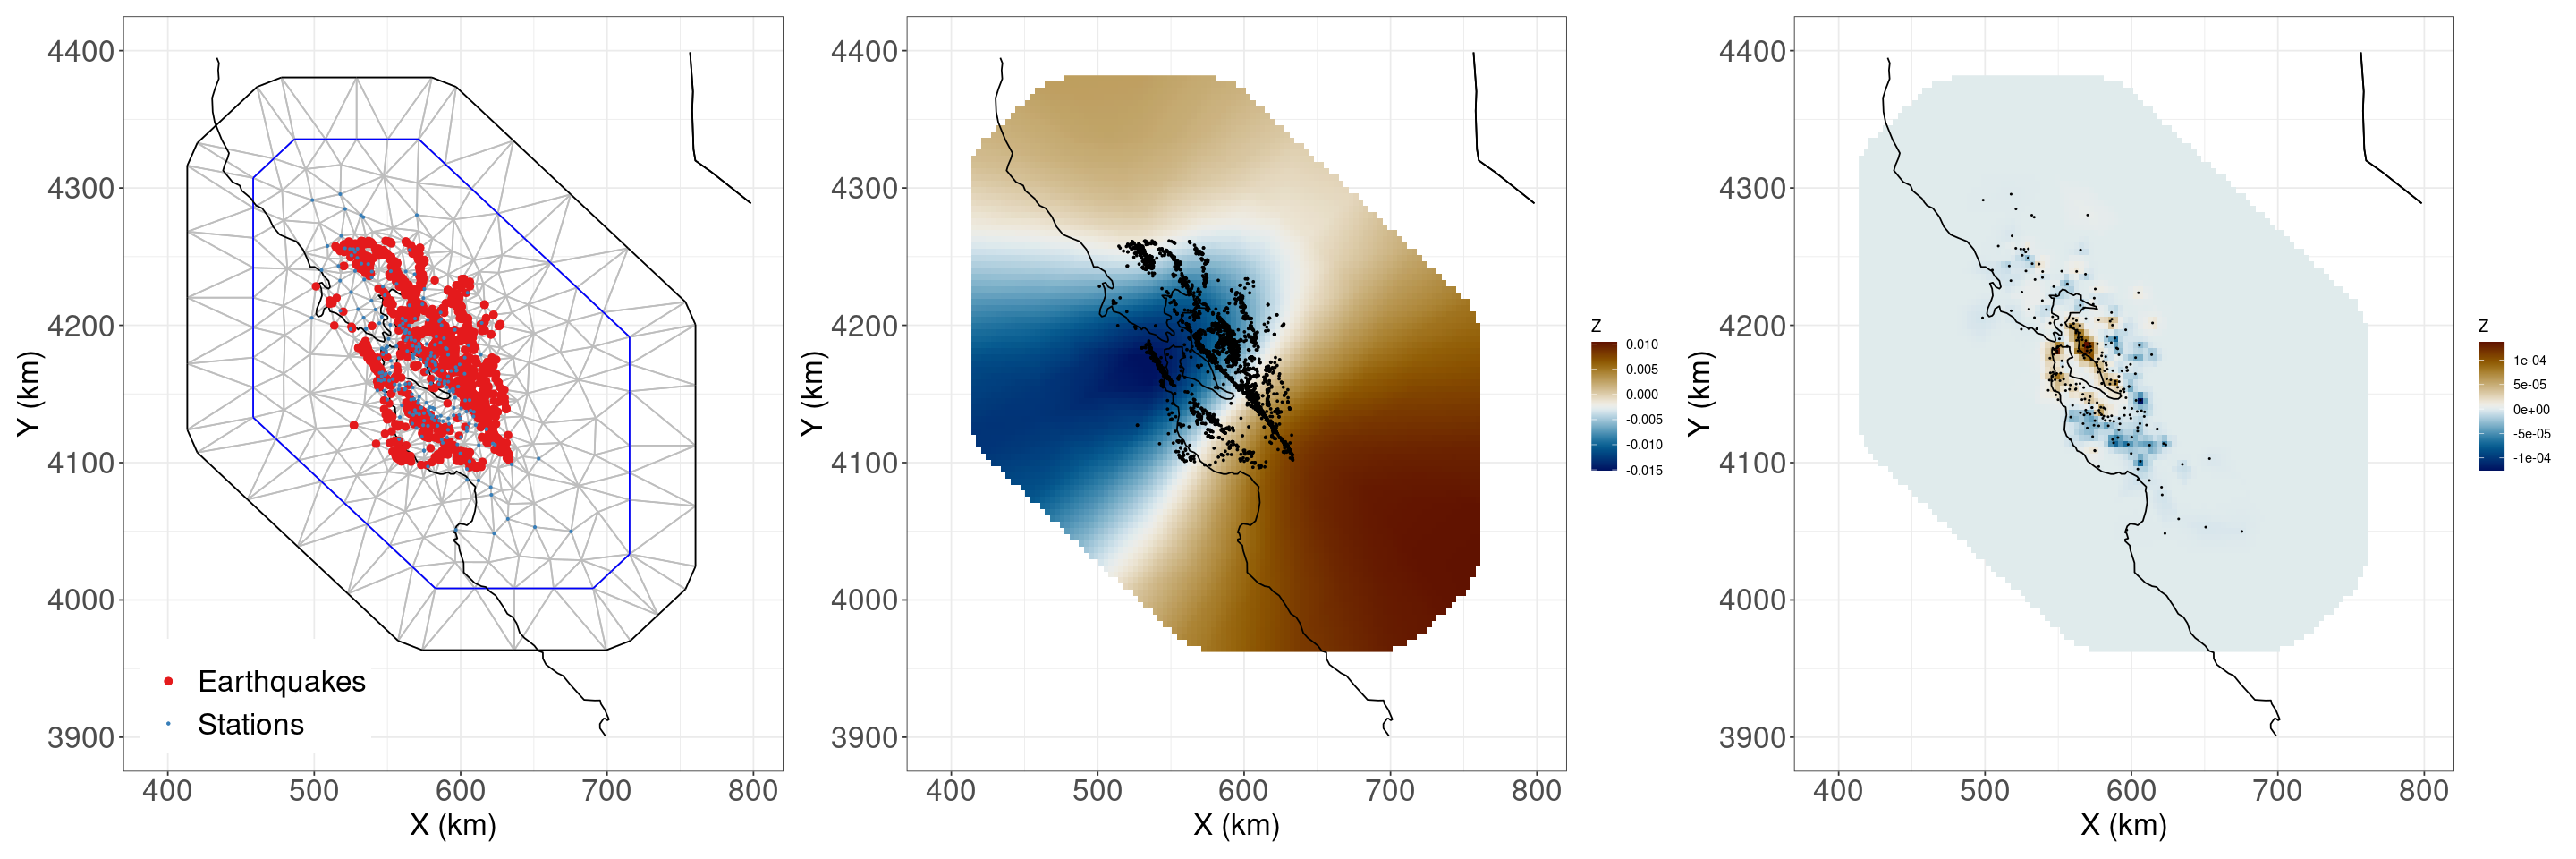

In [36]:
options(repr.plot.width=24, repr.plot.height=8)
pl_mesh + pl_dc_1e_mu_map + pl_dc_1as_mu_map 

In [22]:
# Write Out
  # ---------------------------   
  fig_dir <- file.path(out_dir ,'figures')
  #create output directories
  dir.create(out_dir, showWarnings = FALSE)
  dir.create(fig_dir, showWarnings = FALSE)
  #data files
  # ---   ---   ---   ---   ---
  write.csv(as.data.frame(t(hyp_param)), file=file.path(out_dir,paste0(out_fname,'_inla_hyperparameters','.csv')) )
  write.csv(df_predict_summary,          file=file.path(out_dir,paste0(out_fname,'_inla_residuals',       '.csv')), row.names = FALSE )
  write.csv(df_coeff,  	          file=file.path(out_dir,paste0(out_fname,'_inla_coefficients',    '.csv')), row.names = FALSE )
  write.csv(hyp_posterior,  	          file=file.path(out_dir,paste0(out_fname,'_inla_hyperposterior',  '.csv')), row.names = FALSE )
  
  #figures
  # ---   ---   ---   ---   ---
  #mesh
  ggsave(file.path(fig_dir,paste0(out_fname,'_mesh','.png')),  plot=pl_mesh,  device='png')
  #spatial distribution of coefficients
  ggsave(file.path(fig_dir,paste0(out_fname,'_map_dc_1e_mu','.png')),  plot=pl_dc_1e_mu_map,  device='png')
  ggsave(file.path(fig_dir,paste0(out_fname,'_map_dc_1e_sd','.png')),  plot=pl_dc_1e_sd_map,  device='png')
  ggsave(file.path(fig_dir,paste0(out_fname,'_map_dc_1as_mu','.png')), plot=pl_dc_1as_mu_map, device='png')
  ggsave(file.path(fig_dir,paste0(out_fname,'_map_dc_1as_sd','.png')), plot=pl_dc_1as_sd_map, device='png')
  #posterior distribution
  ggsave(file.path(fig_dir,paste0(out_fname,'_post_dc_0','.png')),      plot=pl_dc_0_post,      device='png')
  ggsave(file.path(fig_dir,paste0(out_fname,'_post_omega_1e','.png')),  plot=pl_omega_1e_post,  device='png')
  ggsave(file.path(fig_dir,paste0(out_fname,'_post_omega_1as','.png')), plot=pl_omega_1as_post, device='png')
  ggsave(file.path(fig_dir,paste0(out_fname,'_post_omega_1bs','.png')), plot=pl_omega_1bs_post, device='png')
  ggsave(file.path(fig_dir,paste0(out_fname,'_post_ell_1e','.png')),    plot=pl_ell_1e_post,    device='png')
  ggsave(file.path(fig_dir,paste0(out_fname,'_post_ell_1as','.png')),   plot=pl_ell_1as_post,   device='png')


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [37]:
#load non-ergodic coefficients and residuals
fname_hparam  <- file.path(dir_out, paste0(reg_name,'_inla_hyperparameters.csv'))
fname_gmotion <- file.path(dir_out, paste0(reg_name,'_inla_residuals.csv'))
fname_coeff   <- file.path(dir_out, paste0(reg_name,'_inla_coefficients.csv'))
df_hparam  <- read.csv(fname_hparam)
df_gmotion <- read.csv(fname_gmotion)
df_coeff   <- read.csv(fname_coeff)

#merge gm-flatfile with non-ergodic coeffs and res 
df_gmotion <- merge(df_flatfile,df_gmotion)
df_coeff   <- merge(df_flatfile,df_coeff)

#print mean and standard deviations of aleatory terms
fprintf('Between-event mean:\t %.3f\n', mean(df_gmotion$res_between))
fprintf('Within-event mean:\t %.3f\n',  mean(df_gmotion$res_within))
fprintf('Between-event std:\t %.3f\n',  sd(df_gmotion$res_between))
fprintf('Within-event std:\t %.3f\n',   sd(df_gmotion$res_within))

Warning message:
“Removed 51 rows containing missing values (geom_point).”
Warning message:
“Removed 51 rows containing missing values (geom_point).”


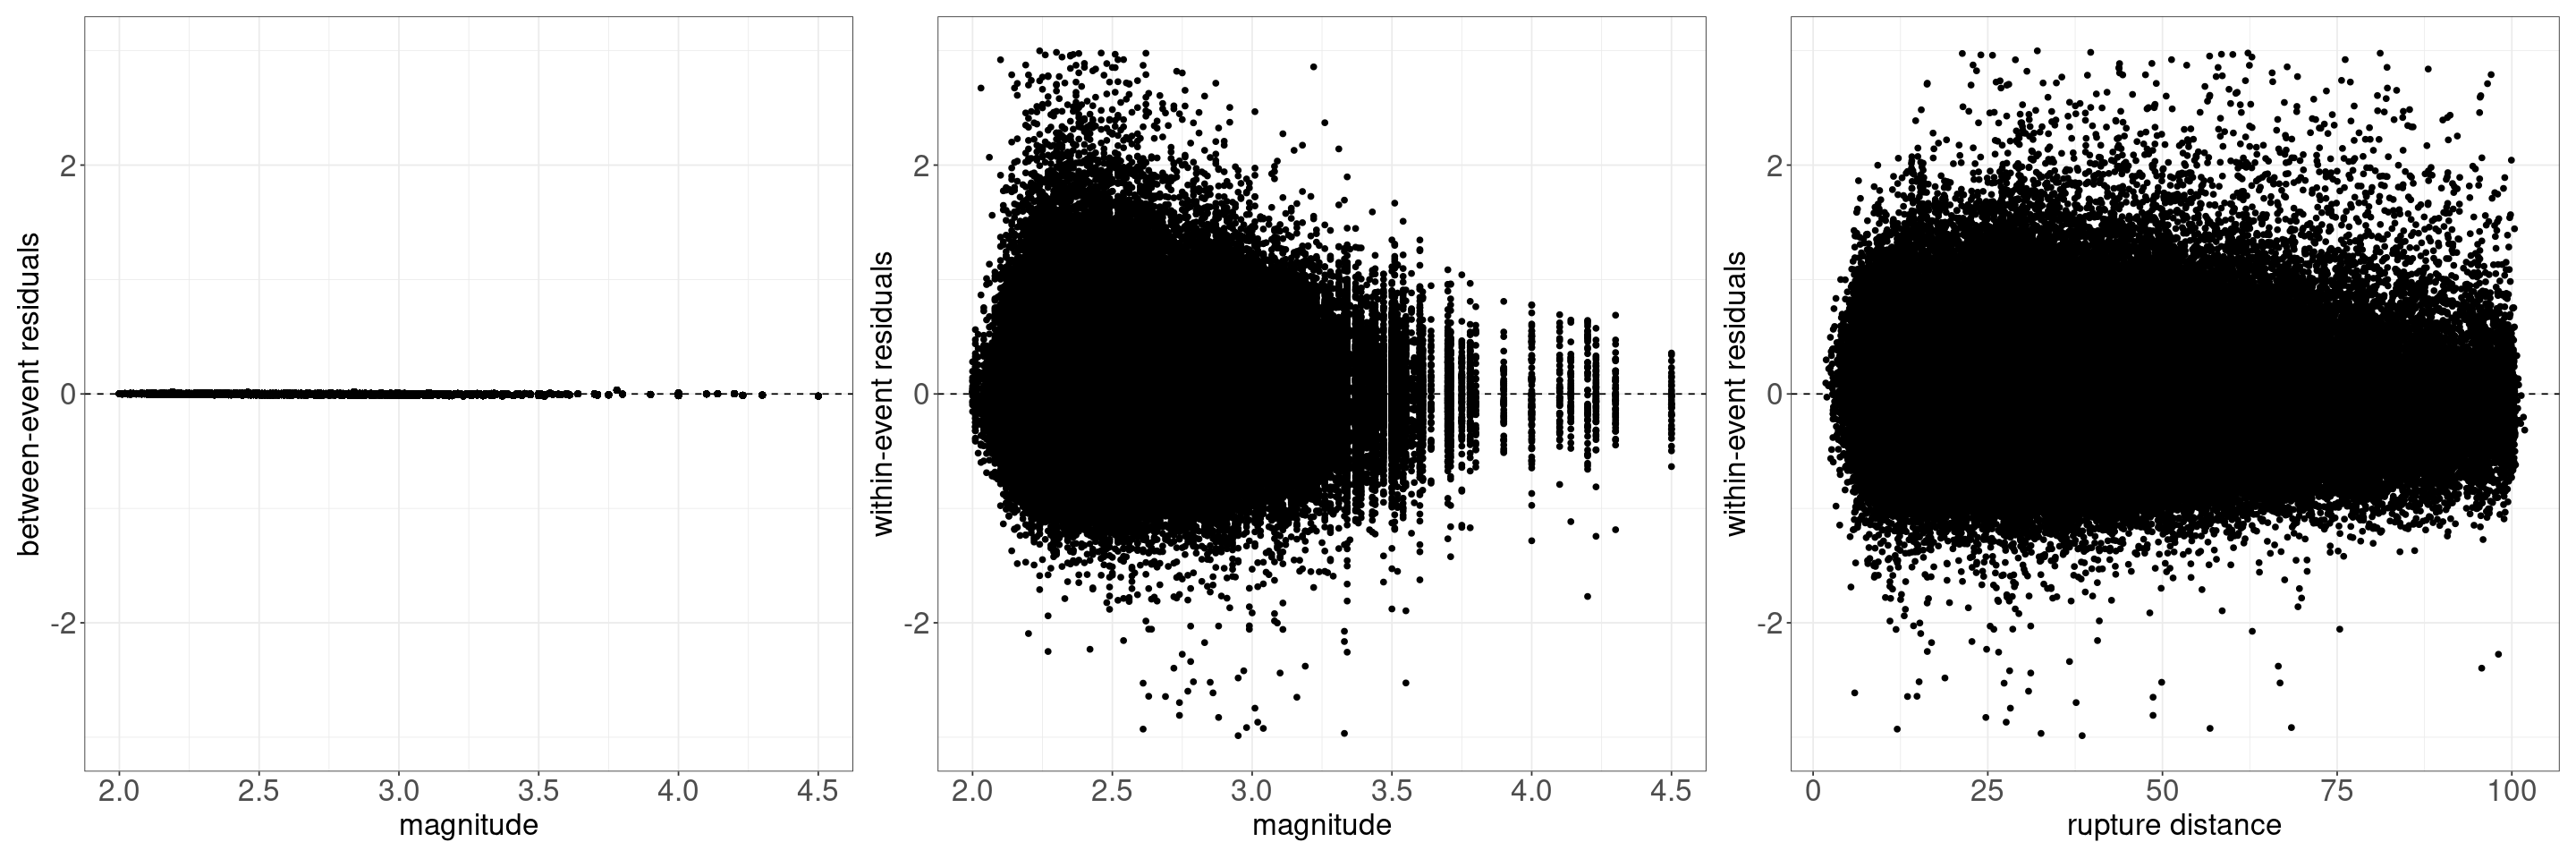

In [52]:


#between-event residuals 
pl_dB_mag <- ggplot(df_gmotion, aes(mag, res_between)) + theme_bw() + ylim(-3,3) + 
              geom_point() + geom_hline(yintercept=0,linetype="dashed") +
              labs(x='magnitude', y='between-event residuals') + 
              theme(axis.title = element_text(size=20), 
                    axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

#within-event residuals 
pl_dW_mag <- ggplot(df_gmotion, aes(mag, res_within)) + theme_bw() +ylim(-3,3) + 
              geom_point() + geom_hline(yintercept=0,linetype="dashed") +
              labs(x='magnitude', y='within-event residuals') + 
              theme(axis.title = element_text(size=20), 
                    axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

pl_dW_Rrup <- ggplot(df_gmotion, aes(R, res_within)) + theme_bw() + ylim(-3,3) + 
               geom_point() + geom_hline(yintercept=0,linetype="dashed") +
               labs(x='rupture distance', y='within-event residuals') + 
               theme(axis.title = element_text(size=20), 
                     axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

pl_dB_mag + pl_dW_mag + pl_dW_Rrup



Warning message:
“Removed 59708 rows containing missing values (geom_point).”
Warning message:
“Removed 59708 rows containing missing values (geom_point).”


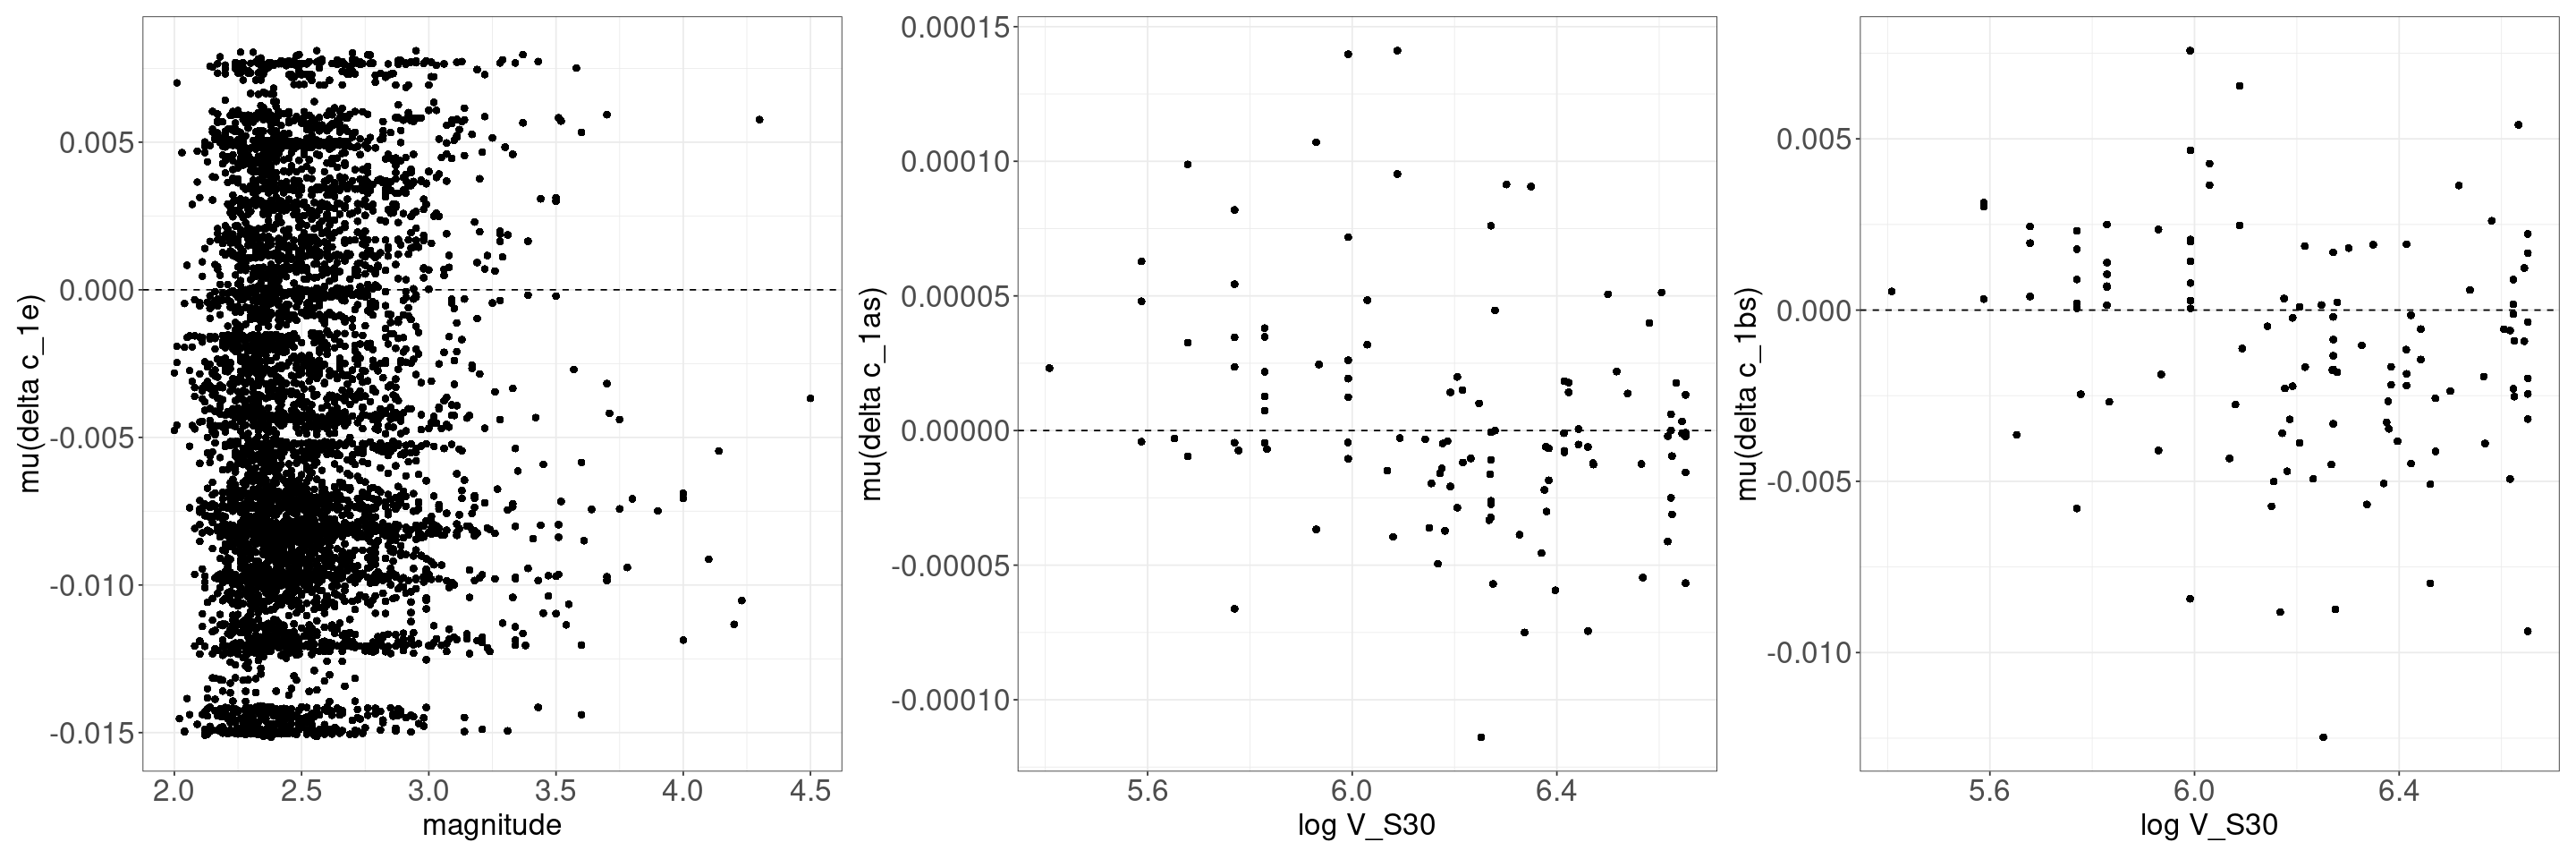

In [54]:


#spatially varying earthquake adjustment
pl_dc1e_mu_mag <- ggplot(df_coeff, aes(mag, dc_1e_mean)) + theme_bw() +
                    geom_point() + geom_hline(yintercept=0,linetype="dashed") +
                    labs(x='magnitude', y='mu(delta c_1e)') + 
                    theme(axis.title = element_text(size=20), 
                          axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

#spatially varying site adjustment
pl_dc1as_mu_vs30 <- ggplot(df_coeff, aes(log(Vs30), dc_1as_mean)) + theme_bw() +
                      geom_point() + geom_hline(yintercept=0,linetype="dashed") +
                      labs(x='log V_S30', y='mu(delta c_1as)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

#spatially independent site adjustment
pl_dc1bs_mu_vs30 <- ggplot(df_coeff, aes(log(Vs30), dc_1bs_mean)) + theme_bw() +
                      geom_point() + geom_hline(yintercept=0,linetype="dashed") +
                      labs(x='log V_S30', y='mu(delta c_1bs)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

pl_dc1e_mu_mag+pl_dc1as_mu_vs30+pl_dc1bs_mu_vs30



In [65]:
#UTM zone
utm_zone <- unique(df_flatfile$UTMzone)
utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))
#California
map_ca     <- subset( map_data("state"), region %in% c("california"))
map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000
#Nevada
map_nv     <- subset( map_data("state"), region %in% c("nevada"))
map_nv_utm <- LongLatToUTM(lat=map_nv$lat, lon=map_nv$long, utm_no)
map_nv[,c('X','Y')] <- map_nv_utm[,c('X','Y')]/1000

#base map
pl_map <- ggplot() + theme_bw() + coord_fixed(ratio = 1) + xlim(390,800) + ylim(3900,4400)+ 
            geom_path(data=map_ca, aes(x=X,y=Y), color='black') + 
            geom_path(data=map_nv, aes(x=X,y=Y), color='black')

#spatially varying earthquake adjustment
pl_dc1e_mu_map <- pl_map + geom_point(data=df_coeff, aes(eqX, eqY, color=dc_1e_mean)) +
                      scale_color_gradientn(colours = rainbow(10)) +
                      labs(x='X (km)', y='Y (km)', color='mu(delta c_1,E)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

pl_dc1e_sd_map <- pl_map + geom_point(data=df_coeff, aes(eqX, eqY, color=dc_1e_sig)) +
                      scale_color_gradientn(colours = rev(rainbow(10))) +
                      labs(x='X (km)', y='Y (km)', color='sd(delta c_1,E)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

#spatially varying site adjustment
pl_dc1as_mu_map <- pl_map + geom_point(data=df_coeff, aes(staX, staY, color=dc_1as_mean)) +
                      scale_color_gradientn(colours = rainbow(10)) +
                      labs(x='X (km)', y='Y (km)', color='mu(delta c_1a,S)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

pl_dc1as_sd_map <- pl_map + geom_point(data=df_coeff, aes(staX, staY, color=dc_1as_sig)) +
                      scale_color_gradientn(colours = rev(rainbow(10))) +
                      labs(x='X (km)', y='Y (km)', color='sd(delta c_1a,S)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

#spatially independent site adjustment
pl_dc1bs_mu_map <- pl_map + geom_point(data=df_coeff, aes(staX, staY, color=dc_1bs_mean)) +
                      scale_color_gradientn(colours = rainbow(10)) +
                      labs(x='X (km)', y='Y (km)', color='mu(delta c_1b,S)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

pl_dc1bs_sd_map <- pl_map + geom_point(data=df_coeff, aes(staX, staY, color=dc_1bs_sig)) +
                      scale_color_gradientn(colours = rev(rainbow(10))) +
                      labs(x='X (km)', y='Y (km)', color='sd(delta c_1b,S)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

Warning message:
“Removed 65 row(s) containing missing values (geom_path).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”
Warning message:
“Removed 65 row(s) containing missing values (geom_path).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”
Warning message:
“Removed 65 row(s) containing missing values (geom_path).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”
Warning message:
“Removed 65 row(s) containing missing values (geom_path).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”
Warning message:
“Removed 65 row(s) containing missing values (geom_path).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”
Warning message:
“Removed 65 row(s) containing missing values (geom_path).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”


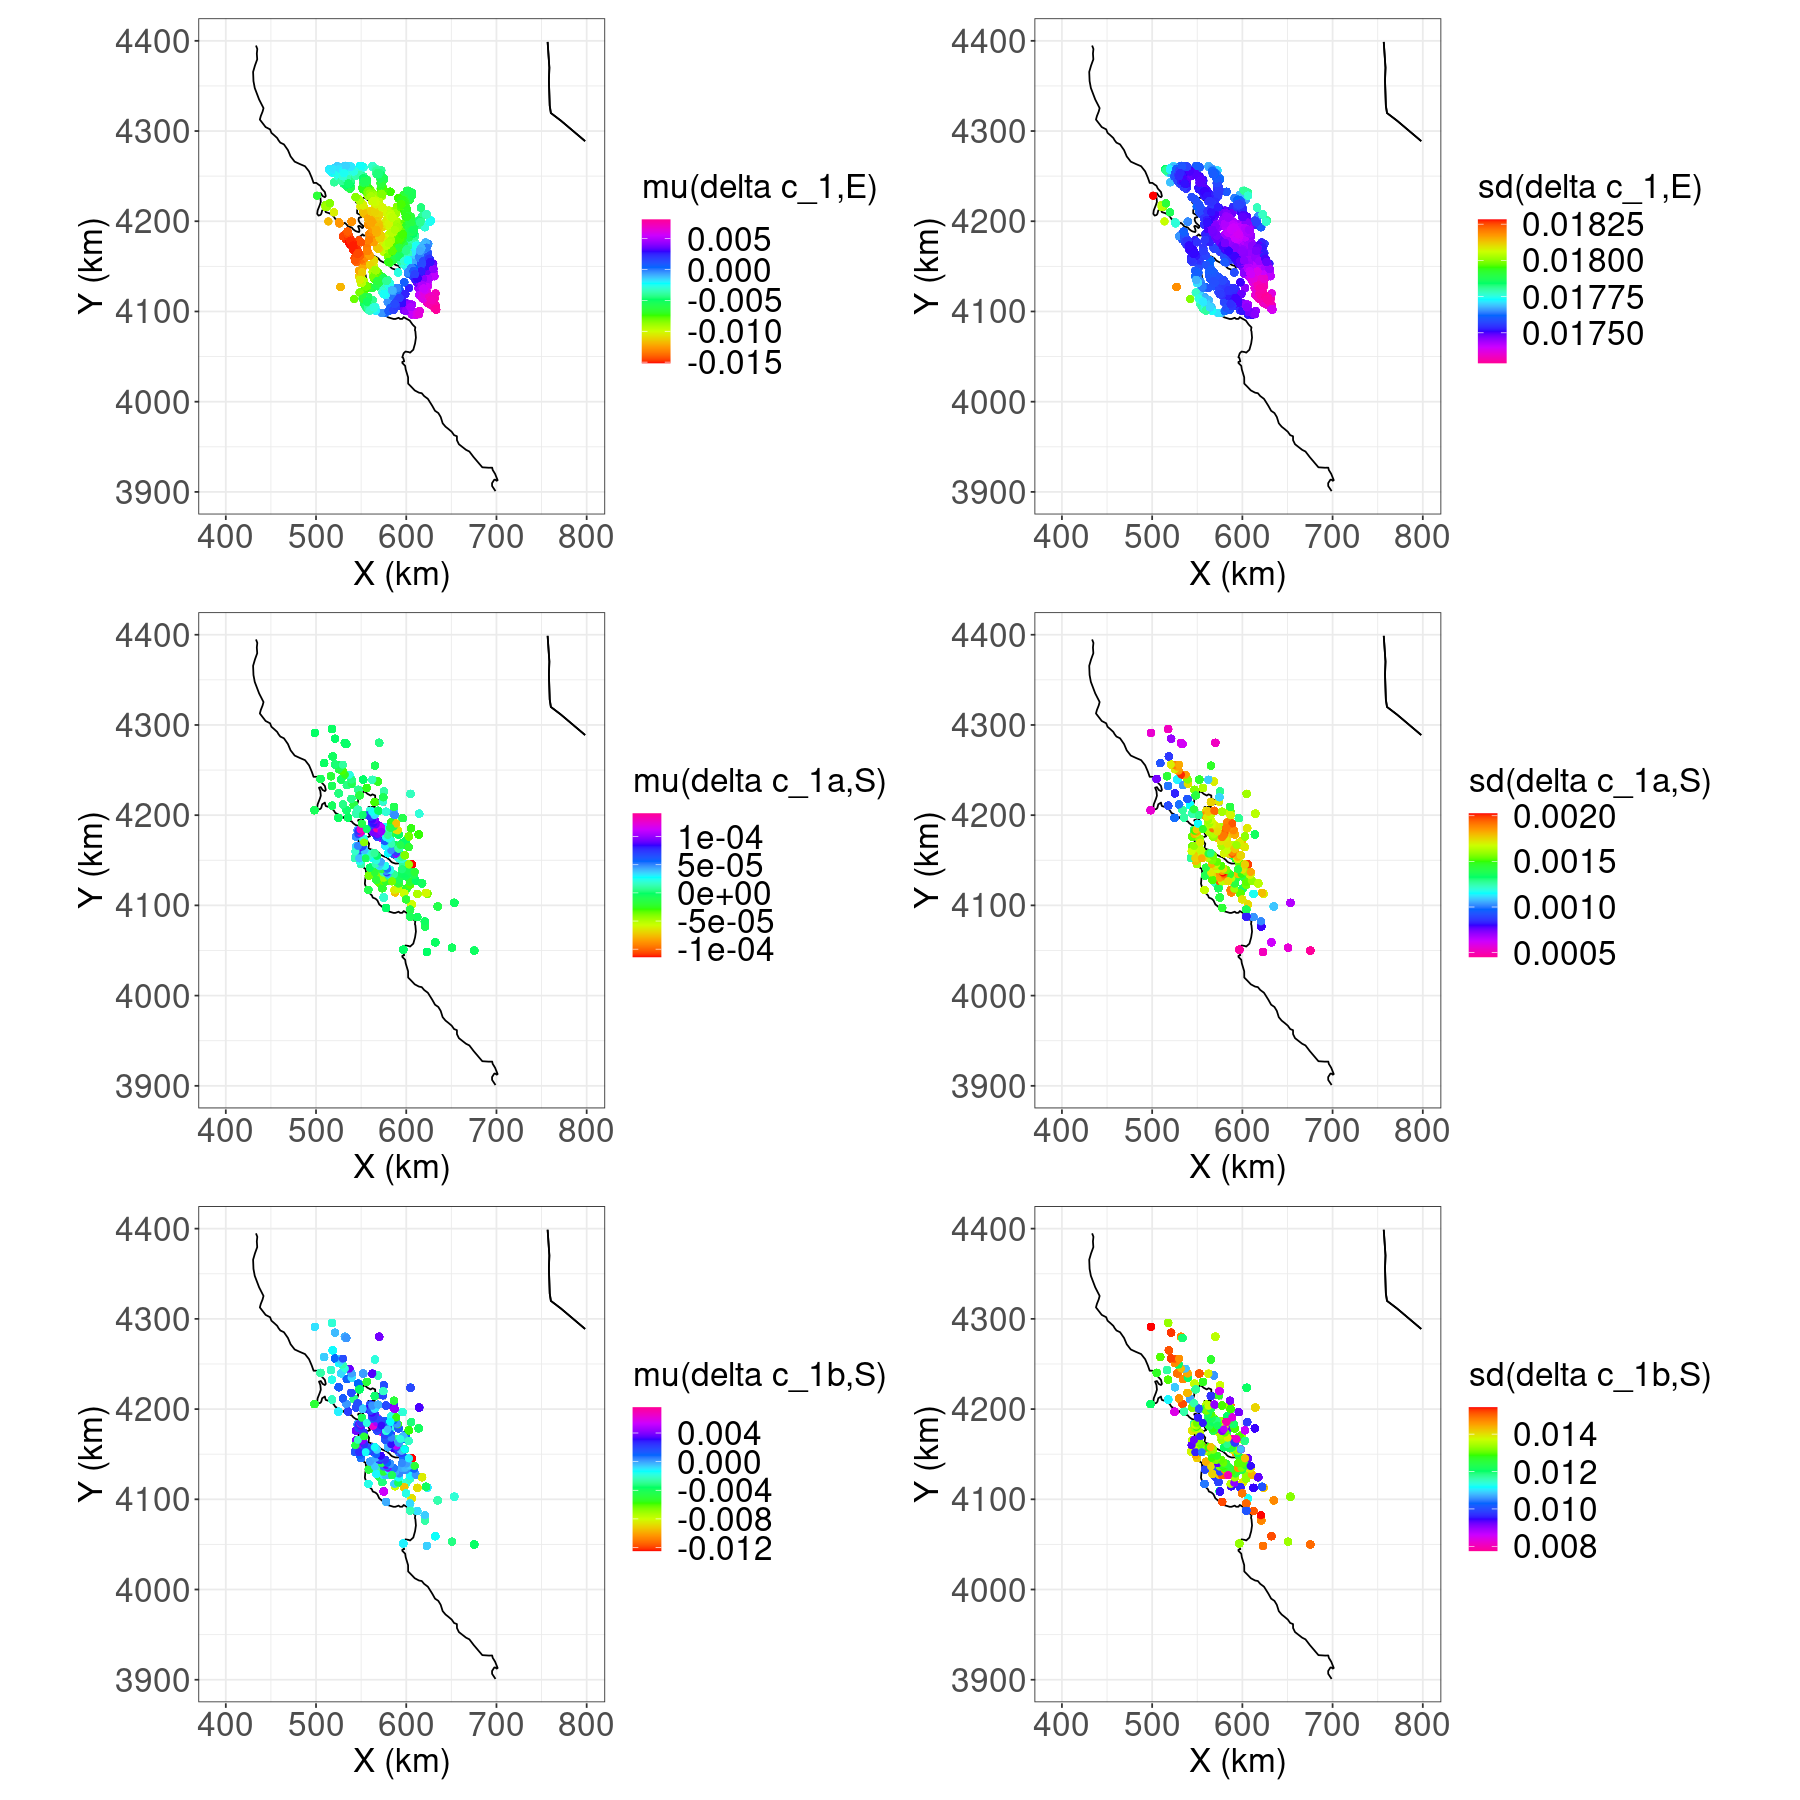

In [66]:

options(repr.plot.width=15, repr.plot.height=15)
pl_dc1e_mu_map + pl_dc1e_sd_map + pl_dc1as_mu_map+pl_dc1as_sd_map + pl_dc1bs_mu_map+ pl_dc1bs_sd_map +  plot_layout(ncol = 2)

